In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

2025-03-01 12:54:29.572719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 12:54:29.582323: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 12:54:29.585976: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 12:54:29.597805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740830069.617151   25419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740830069.62

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured:", gpus)
    except RuntimeError as e:
        print("RuntimeError:", e)
else:
    print("No GPU detected by TensorFlow")


No GPU detected by TensorFlow


2025-03-01 12:54:32.676720: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
from data_loading import OxfordPetDataset
from augmentation import augmentation_layers_geometric, augmentation_layers_color, augment_image_mask, batch
from models import UNet_model #2.a, 2.b exercises
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)
dataset.mask_prep()

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


In [4]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    print(data)
    return data['image'], data['image']

# Apply to all datasets
train1 = train.map(extract_image_mask)
val1 = val.map(extract_image_mask)
test1 = test.map(extract_image_mask)

{'image': <tf.Tensor 'args_0:0' shape=(256, 256, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(256, 256, 1) dtype=uint8>, 'species': <tf.Tensor 'args_3:0' shape=() dtype=int64>}
{'image': <tf.Tensor 'args_0:0' shape=(256, 256, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(256, 256, 1) dtype=uint8>, 'species': <tf.Tensor 'args_3:0' shape=() dtype=int64>}
{'image': <tf.Tensor 'args_0:0' shape=(256, 256, 3) dtype=float32>, 'label': <tf.Tensor 'args_1:0' shape=(37,) dtype=float32>, 'segmentation_mask': <tf.Tensor 'args_2:0' shape=(256, 256, 1) dtype=uint8>, 'species': <tf.Tensor 'args_3:0' shape=() dtype=int64>}


In [ ]:
BATCH_SIZE = 32

# Batch the data and use prefetching to optimize loading speed
# Apply augmentation dynamically during training: 
# none = no augmentation, geometric = [geometric], color = [color], both = [gemoeetric + color]
train_ds = batch(train1, augment='both', batch_size=BATCH_SIZE)
val_ds = batch(val1, augment='none', batch_size=BATCH_SIZE)
test_ds = batch(test1, augment='none', batch_size=BATCH_SIZE)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
from models import Autoencoder
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

# Create top-level folder and subdirectories if they don't exist
top_dir = "task_2b/baseline"
results_dir = os.path.join(top_dir, "autoencoder_results")
models_dir = os.path.join(top_dir, "autoencoder_models")
weights_dir = os.path.join(top_dir, "autoencoder_weights")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

# Define folder for saving the best autoencoder model
best_model_folder = os.path.join(top_dir, "Autoencoded_model")

# Initialize and compile autoencoder
autoencoder = Autoencoder(input_shape=(256, 256, 3))
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Define Early Stopping (restores best weights)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

# Define ModelCheckpoint to save the best model into the specified folder
checkpoint = ModelCheckpoint(
    best_model_folder,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model with early stopping & 100 epochs (adjust epochs as needed)
history = autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[checkpoint, early_stopping]
)



Training history saved at: task_2b/baseline\autoencoder_results\autoencoder_training.csv


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\autoencoder_training_tf\assets


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\autoencoder_training_tf\assets


Autoencoder model saved at: task_2b/baseline\autoencoder_models\autoencoder_training_tf
Autoencoder weights saved at: task_2b/baseline\autoencoder_weights\autoencoder_weights.h5


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\encoder_training_tf\assets


INFO:tensorflow:Assets written to: task_2b/baseline\autoencoder_models\encoder_training_tf\assets


Encoder model saved at: task_2b/baseline\autoencoder_models\encoder_training_tf
Encoder weights saved at: task_2b/baseline\autoencoder_weights\encoder_weights.h5


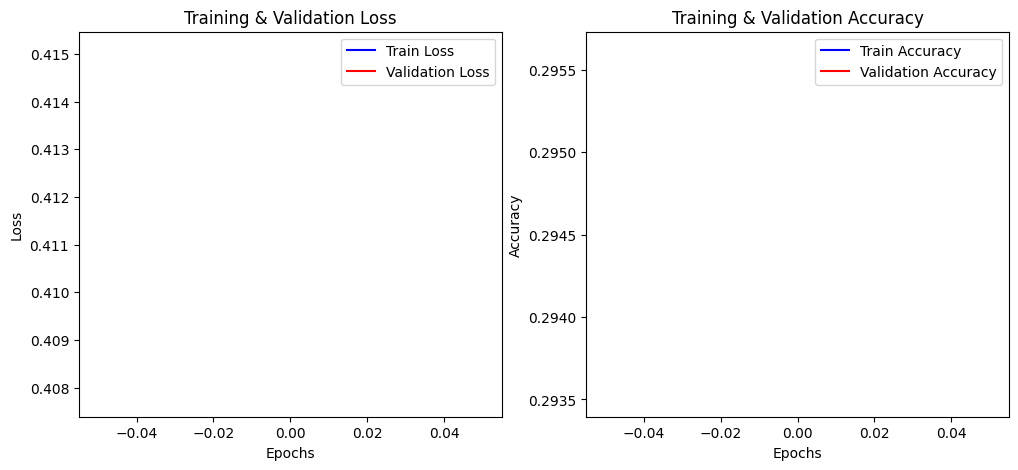

In [ ]:
# Load the best model from the folder
best_autoencoder = tf.keras.models.load_model(best_model_folder)

# Save training history to CSV in the results folder
history_df = pd.DataFrame(history.history)
csv_path = os.path.join(results_dir, "autoencoder_training.csv")
history_df.to_csv(csv_path, index=False)
print(f"Training history saved at: {csv_path}")

# Save the final autoencoder model (from the best model) in TensorFlow format
autoencoder_model_path = os.path.join(models_dir, "autoencoder_training_tf")
best_autoencoder.save(autoencoder_model_path, save_format="tf")
print(f"Autoencoder model saved at: {autoencoder_model_path}")

# Save only the autoencoder weights
autoencoder_weights_path = os.path.join(weights_dir, "autoencoder_weights.h5")
best_autoencoder.save_weights(autoencoder_weights_path)
print(f"Autoencoder weights saved at: {autoencoder_weights_path}")

# Extract and save the encoder part of the autoencoder
encoder = best_autoencoder.encoder
encoder_model_path = os.path.join(models_dir, "encoder_training_tf")
encoder.save(encoder_model_path, save_format="tf")
print(f"Encoder model saved at: {encoder_model_path}")

# Save only the encoder weights
encoder_weights_path = os.path.join(weights_dir, "encoder_weights.h5")
encoder.save_weights(encoder_weights_path)
print(f"Encoder weights saved at: {encoder_weights_path}")

# Plot Training & Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Train Loss', color='blue')
plt.plot(history_df['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")

plt.show()

Autoencoder Model Weights Loaded Successfully from task_2b/baseline\autoencoder_weights\autoencoder_weights.h5
1/1 [==============================] - 0s 241ms/step


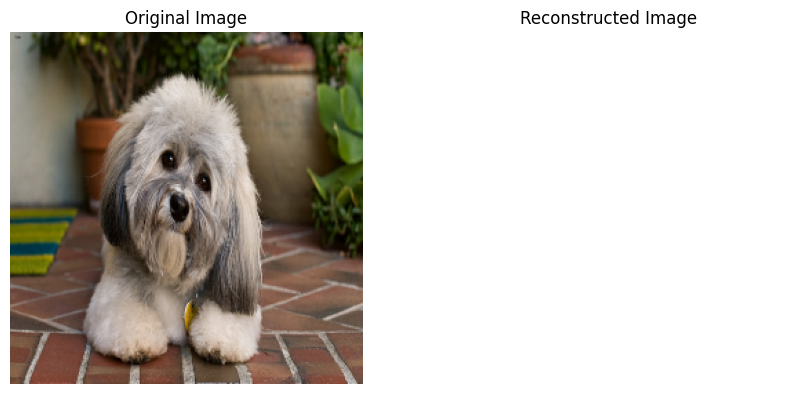

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from models import Autoencoder

# Define folder paths for weights

# Define subdirectories
weights_dir = os.path.join(top_dir, "autoencoder_weights")
autoencoder_weights_path = os.path.join(weights_dir, "autoencoder_weights.h5")

# Rebuild the autoencoder model
autoencoder = Autoencoder(input_shape=(256, 256, 3))

# Build the model by calling it with a dummy input
dummy_input = tf.random.normal((1, 256, 256, 3))  # Batch size of 1
autoencoder(dummy_input)  # Ensures layers are built

# Load the saved weights
if os.path.exists(autoencoder_weights_path):
    autoencoder.load_weights(autoencoder_weights_path)
    print(f"Autoencoder Model Weights Loaded Successfully from {autoencoder_weights_path}")
else:
    raise FileNotFoundError(f"Error: Weights file not found at {autoencoder_weights_path}")

# Fetch a batch from the test dataset
test_batch = next(iter(test_ds))  # Get one batch (batch_size, 256, 256, 3)
test_images = test_batch[0].numpy()  # Convert to NumPy array

# Select a random image
random_idx = random.randint(0, test_images.shape[0] - 1)
test_img = np.expand_dims(test_images[random_idx], axis=0)  # Add batch dimension

# Predict (Reconstruct) the image
pred = autoencoder.predict(test_img)

# Display Original & Reconstructed Image
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(test_img[0])  # Remove batch dimension
plt.title('Original Image')
plt.axis("off")

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(pred[0])  # Remove batch dimension
plt.title('Reconstructed Image')
plt.axis("off")

plt.show()


In [ ]:
import tensorflow as tf
import pandas as pd
import os
from models import Autoencoder


# Define paths for saved weights
autoencoder_weights_path = os.path.join(weights_dir, "autoencoder_weights.h5")

# Rebuild the autoencoder model
autoencoder = Autoencoder(input_shape=(256, 256, 3))

# Build the model by calling it with a dummy input
dummy_input = tf.random.normal((1, 256, 256, 3))  # Batch size of 1
autoencoder(dummy_input)  # Ensures layers are built

# Load the saved weights
if os.path.exists(autoencoder_weights_path):
    autoencoder.load_weights(autoencoder_weights_path)
    print(f"Autoencoder Model Weights Loaded Successfully from {autoencoder_weights_path}")
else:
    raise FileNotFoundError(f"Error: Weights file not found at {autoencoder_weights_path}")

# Evaluate the model on the test dataset
autoencoder.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
test_loss, test_accuracy = autoencoder.evaluate(test_ds)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save test results to CSV
test_results = pd.DataFrame({
    "Metric": ["Test Loss", "Test Accuracy"],
    "Value": [test_loss, test_accuracy]
})
csv_path = os.path.join(results_dir, "autoencoder_test_results.csv")
test_results.to_csv(csv_path, index=False)
print(f"Test results saved at: {csv_path}")


Autoencoder Model Weights Loaded Successfully from task_2b/baseline\autoencoder_weights\autoencoder_weights.h5
115/115 [==============================] - 11s 94ms/step - loss: 0.4228 - accuracy: 0.2999
Test Loss: 0.4228
Test Accuracy: 0.2999
Test results saved at: task_2b/baseline\autoencoder_results\autoencoder_test_results.csv


In [ ]:
def process_image_mask(data):
    """Extract image and mask from dictionary"""
    return data['image'], data['segmentation_mask']

# Apply to all datasets
train = train.map(process_image_mask)
val = val.map(process_image_mask)
test = test.map(process_image_mask)

BATCH_SIZE = 32

# Batch the data and use prefetching to optimize loading speed
# Apply augmentation dynamically during training: 
# none = no augmentation, geometric = [geometric], color = [color], both = [gemoeetric + color]
train_ds = batch(train, augment='both', batch_size=BATCH_SIZE)
val_ds = batch(val, augment='none', batch_size=BATCH_SIZE)
test_ds = batch(test, augment='none', batch_size=BATCH_SIZE)



In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from models import build_segmentation_decoder

# Paths where your encoder is saved
top_dir = "task_2b/baseline"

models_dir = os.path.join(top_dir, "autoencoder_models")
weights_dir = os.path.join(top_dir,"autoencoder_weights")


encoder_model_path = os.path.join(models_dir, "encoder_training_tf")
encoder_weights_path = os.path.join(weights_dir, "encoder_weights.h5")

# Load the Pretrained Encoder
encoder = tf.keras.models.load_model(encoder_model_path)
encoder.load_weights(encoder_weights_path)
print("✅ Pretrained encoder loaded successfully!")

# Build U-Net with pretrained encoder
model = build_segmentation_decoder(encoder, num_classes=3)

### **🔹 Compile Model for Multi-Class Segmentation**
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



✅ Pretrained encoder loaded successfully!


In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from metrics import MeanIoUWrapper, dice_coefficient
from models import build_segmentation_decoder  


# Instantiate the metric once
miou_metric = MeanIoUWrapper(num_classes=3)

# Directories for the pretrained encoder (assumed to be already saved)
encoder_models_dir = os.path.join(top_dir, "autoencoder_models")  
encoder_weights_dir = os.path.join(top_dir, "autoencoder_weights")

# Directory for saving the best segmentation model
segmentation_model_dir = os.path.join(top_dir, "segmentation_pretrained_model")
os.makedirs(segmentation_model_dir, exist_ok=True)

# Directory for saving training results CSV
results_dir = os.path.join(top_dir, "segmentation_results")
os.makedirs(results_dir, exist_ok=True)

# Define the folder path for the best segmentation model (SavedModel format)
best_model_folder = os.path.join(segmentation_model_dir, "segmentation_model_with_pretrained_encoder")

# Load Pretrained Encoder
encoder_model_path = os.path.join(encoder_models_dir, "encoder_training_tf")
encoder_weights_path = os.path.join(encoder_weights_dir, "encoder_weights.h5")
encoder = tf.keras.models.load_model(encoder_model_path)
encoder.load_weights(encoder_weights_path)
print("Pretrained encoder loaded successfully!")

# Build Segmentation Model with Pretrained Encoder
segmentation_model = build_segmentation_decoder(encoder, num_classes=3)


segmentation_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', miou_metric, dice_coefficient]
)

# Define callbacks: Using SavedModel format to avoid HDF5 conflicts.
checkpoint = ModelCheckpoint(
    best_model_folder,  # This is a folder, not a file
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_format='tf'  # Save as TensorFlow SavedModel
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the segmentation model (adjust epochs as needed)
history = segmentation_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping, checkpoint]
)

Pretrained encoder loaded successfully!
104/104 [==============================] - ETA: 0s - loss: 1.1261 - accuracy: 0.6196 - mean_iou: 0.2683 - dice_coefficient: 0.6200   
Epoch 1: val_loss improved from inf to 0.77042, saving model to task_2b/baseline\segmentation_pretrained_model\segmentation_model_with_pretrained_encoder


INFO:tensorflow:Assets written to: task_2b/baseline\segmentation_pretrained_model\segmentation_model_with_pretrained_encoder\assets


INFO:tensorflow:Assets written to: task_2b/baseline\segmentation_pretrained_model\segmentation_model_with_pretrained_encoder\assets


104/104 [==============================] - 45s 322ms/step - loss: 1.1261 - accuracy: 0.6196 - mean_iou: 0.2683 - dice_coefficient: 0.6200 - val_loss: 0.7704 - val_accuracy: 0.6739 - val_mean_iou: 0.3223 - val_dice_coefficient: 0.6732


In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as t


best_model = tf.keras.models.load_model(best_model_folder, compile=False)
# # Load the model without compiling to avoid custom object restoration issues.
# best_model = tf.keras.models.load_model(best_model_folder, compile=False)

# # Re-compile the model with the custom metrics.
best_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', MeanIoUWrapper(num_classes=3), dice_coefficient]
)

# # # Evaluate on validation set
val_metrics = best_model.evaluate(val_ds, return_dict=True)
val_loss = val_metrics['loss']
val_accuracy = val_metrics['accuracy']
val_iou = val_metrics['mean_iou']
val_dice = val_metrics['dice_coefficient']

# # # Evaluate on test set
test_metrics = best_model.evaluate(test_ds, return_dict=True)
print(test_metrics)
test_loss = test_metrics['loss']
test_accuracy = test_metrics['accuracy']
test_iou = test_metrics['mean_iou']
test_dice = test_metrics['dice_coefficient']


# Save test results in a separate CSV file
test_results = {
    "Loss": [test_loss],
    "Accuracy": [test_accuracy],
    "IoU": [test_iou],
    "Dice Coefficient": [test_dice]
}
test_results_df = pd.DataFrame(test_results)
test_csv_path = os.path.join(results_dir, "test_metrics.csv")
test_results_df.to_csv(test_csv_path, index=False)
print(f"Test metrics saved to {test_csv_path}")

# Plot training curves and save training history if available.
# 'history' is assumed to be a variable obtained from model.fit() during training.
if 'history' in globals():
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    loss_plot_path = os.path.join(results_dir, "loss_plot.png")
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved to {loss_plot_path}")

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    accuracy_plot_path = os.path.join(results_dir, "accuracy_plot.png")
    plt.savefig(accuracy_plot_path)
    plt.close()
    print(f"Accuracy plot saved to {accuracy_plot_path}")

    # Plot training and validation IoU
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mean_iou'], label='Training IoU')
    plt.plot(history.history['val_mean_iou'], label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    iou_plot_path = os.path.join(results_dir, "iou_plot.png")
    plt.savefig(iou_plot_path)
    plt.close()
    print(f"IoU plot saved to {iou_plot_path}")

    # Plot training and validation Dice Coefficient
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    dice_plot_path = os.path.join(results_dir, "dice_plot.png")
    plt.savefig(dice_plot_path)
    plt.close()
    print(f"Dice Coefficient plot saved to {dice_plot_path}")

    # Save the training history to a CSV file
    history_df = pd.DataFrame(history.history)
    history_csv_path = os.path.join(results_dir, "training_history.csv")
    history_df.to_csv(history_csv_path, index=False)
    print(f"Training history saved to {history_csv_path}")
else:
    print("Training history is not available as 'history' variable.")

# Print evaluation results
print("\nBest Model Validation Metrics:")
print(f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
print(f"IoU: {val_iou:.4f}, Dice Coefficient: {val_dice:.4f}, Pixel Accuracy: {val_accuracy:.4f}")

print("\nBest Model Test Metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
print(f"IoU: {test_iou:.4f}, Dice Coefficient: {test_dice:.4f}, Pixel Accuracy: {test_accuracy:.4f}")


115/115 [==============================] - 14s 122ms/step - loss: 0.7893 - accuracy: 0.6618 - mean_iou: 0.3187 - dice_coefficient: 0.6619
{'loss': 0.7893164753913879, 'accuracy': 0.6618126034736633, 'mean_iou': 0.31867504119873047, 'dice_coefficient': 0.6619127988815308}
Test metrics saved to task_2b/baseline\segmentation_results\test_metrics.csv
Loss plot saved to task_2b/baseline\segmentation_results\loss_plot.png
Accuracy plot saved to task_2b/baseline\segmentation_results\accuracy_plot.png
IoU plot saved to task_2b/baseline\segmentation_results\iou_plot.png
Dice Coefficient plot saved to task_2b/baseline\segmentation_results\dice_plot.png
Training history saved to task_2b/baseline\segmentation_results\training_history.csv

Best Model Validation Metrics:
Loss: 0.7704, Accuracy: 0.6739
IoU: 0.3223, Dice Coefficient: 0.6732, Pixel Accuracy: 0.6739

Best Model Test Metrics:
Loss: 0.7893, Accuracy: 0.6618
IoU: 0.3187, Dice Coefficient: 0.6619, Pixel Accuracy: 0.6618
